In [3]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.vector_ar.vecm import *


Functions used later in the code

In [18]:
def run_tests_c(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='c')
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Phillips Perron Test
    result = PhillipsPerron(data, trend='ct')
    test_statistic = round(result.stat, 2)
    pp_p_value = result.pvalue

    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if 1 - p_value > 0.01:
        asterisk_pp = '***'
    elif 1 - p_value < 0.05:
        asterisk_pp = '**'
    elif 1 - p_value < 0.1:
        asterisk_pp = '*'
    else:
        asterisk_pp = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    summary_df.loc['PhillipsPerron Test', variable.name] = str(test_statistic) + asterisk_pp
    
    return summary_df

def run_tests_ct(variable, summary_df):
    # ADF Test
    data = variable.dropna()
    result = adfuller(data, regression='ct')
    adf_statistic = round(result[0], 2)
    p_value = result[1]
    
    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if p_value < 0.01:
        asterisk_adf = '***'
    elif p_value < 0.05:
        asterisk_adf = '**'
    elif p_value < 0.1:
        asterisk_adf = '*'
    else:
        asterisk_adf = ''
    
    # Phillips Perron Test
    result = PhillipsPerron(data, trend='ct')
    test_statistic = round(result.stat, 2)
    pp_p_value = result.pvalue

    # Check if p-value is lower than 0.01, 0.05, or 0.1
    if 1 - p_value < 0.01:
        asterisk_pp = '***'
    elif 1 - p_value < 0.05:
        asterisk_pp = '**'
    elif 1 - p_value < 0.1:
        asterisk_pp = '*'
    else:
        asterisk_pp = ''
    
    # Check if column exists in summary_df and if not, create it
    if variable.name not in summary_df.columns:
        summary_df[variable.name] = np.nan
    
    # Add test statistics to summary_df
    summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
    summary_df.loc['PhillipsPerron Test', variable.name] = str(test_statistic) + asterisk_pp
    
    return summary_df

def pp_nlag(variable, reg, lag_df):
    data = variable.dropna()
    result = PhillipsPerron(data, trend= reg)

    if variable.name not in lag_df.columns:
        lag_df[variable.name] = np.nan
    
        # Add test statistics to summary_df
        lag_df.loc['nlags', variable.name] = result.lags

    return lag_df

In [5]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Male the inflation index with base 1 instead of 100
industries = data.iloc[:,6:].columns
industry_names = industries.tolist()
industry_names

nominal_vars = data[industry_names + ['GDP' , 'M1SL' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

real_vars['PCEPI'] = data['PCEPI']

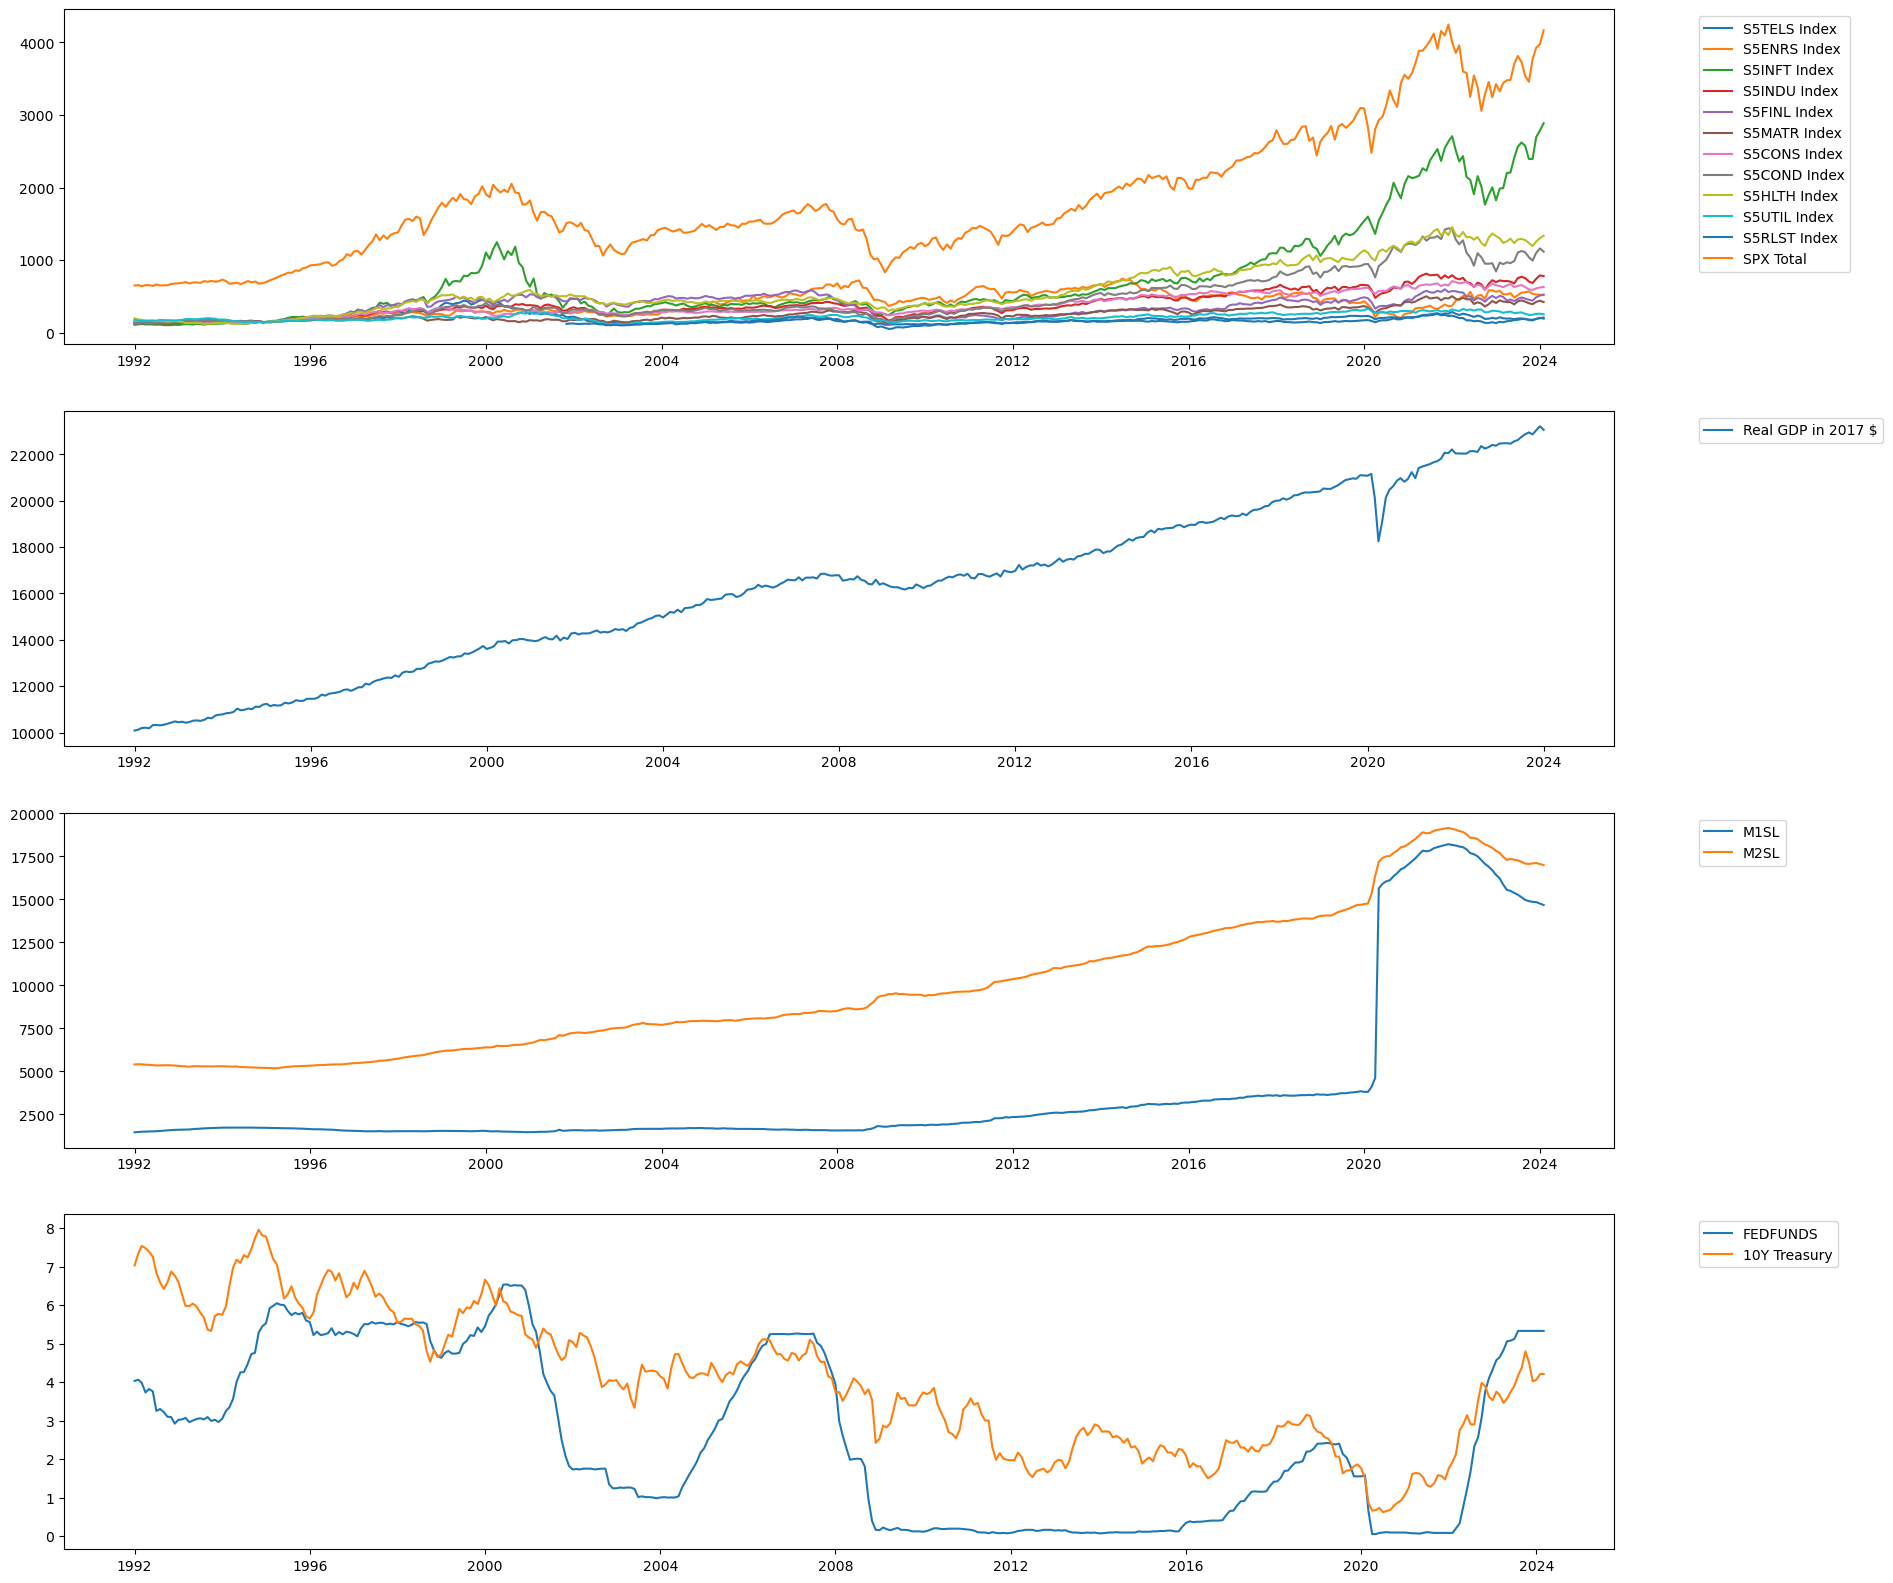

In [6]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(411)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(real_vars.index, real_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

We perform A standard ADF and Phillips Perrin test for stationarity. The Phillips Perrin methodologyaccounts for Newey west standard errors (robust to serial correlation and heteroskedasticity). We find that S5MATR Index is stationary under the ADF test.

Information technologies and the total S&P 500 are stationary under the PP tests.


In [7]:
summary_df = pd.DataFrame(index=['ADF Test', 'PhillipsPerron Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(real_vars[industry], summary_df)

run_tests_ct(real_vars['GDP'], summary_df)
run_tests_ct(real_vars['M1SL'], summary_df)
run_tests_ct(real_vars['M2SL'], summary_df)
run_tests_c(data['FEDFUNDS'], summary_df)
run_tests_c(data['10Y Treasury'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.88' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.13' has dt

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,FEDFUNDS,10Y Treasury
ADF Test,-2.88,-2.1,-0.13,-2.48,-2.19,-3.53**,-1.81,-1.79,-1.28,-3.23*,-2.71,-0.91,-1.82,-1.41,-2.95,-2.74*,-2.21
PhillipsPerron Test,-2.45,-2.4,-0.05***,-2.36,-2.09,-3.56,-2.41,-1.85,-1.38,-2.97,-2.84,-1.2**,-2.79,-1.63,-2.23,-1.68***,-1.98***


Given the previous results, we implement Newey West standard errors to account for the heteroskedasticty of the error terms. All variables become non-stationary.

Given the shape of the graphs, it seems that there may be a compounding effect going on with the industry indeces. We thus convert them to logs and perform the standard ADF test. With this specification, S5MATR Index, S5UTIL Index and M2 are all stationary.

In [8]:
log_vars = np.log(real_vars)

treated_vars = log_vars.copy()
treated_vars[['FEDFUNDS', '10Y Treasury']] = data[['FEDFUNDS', '10Y Treasury']]

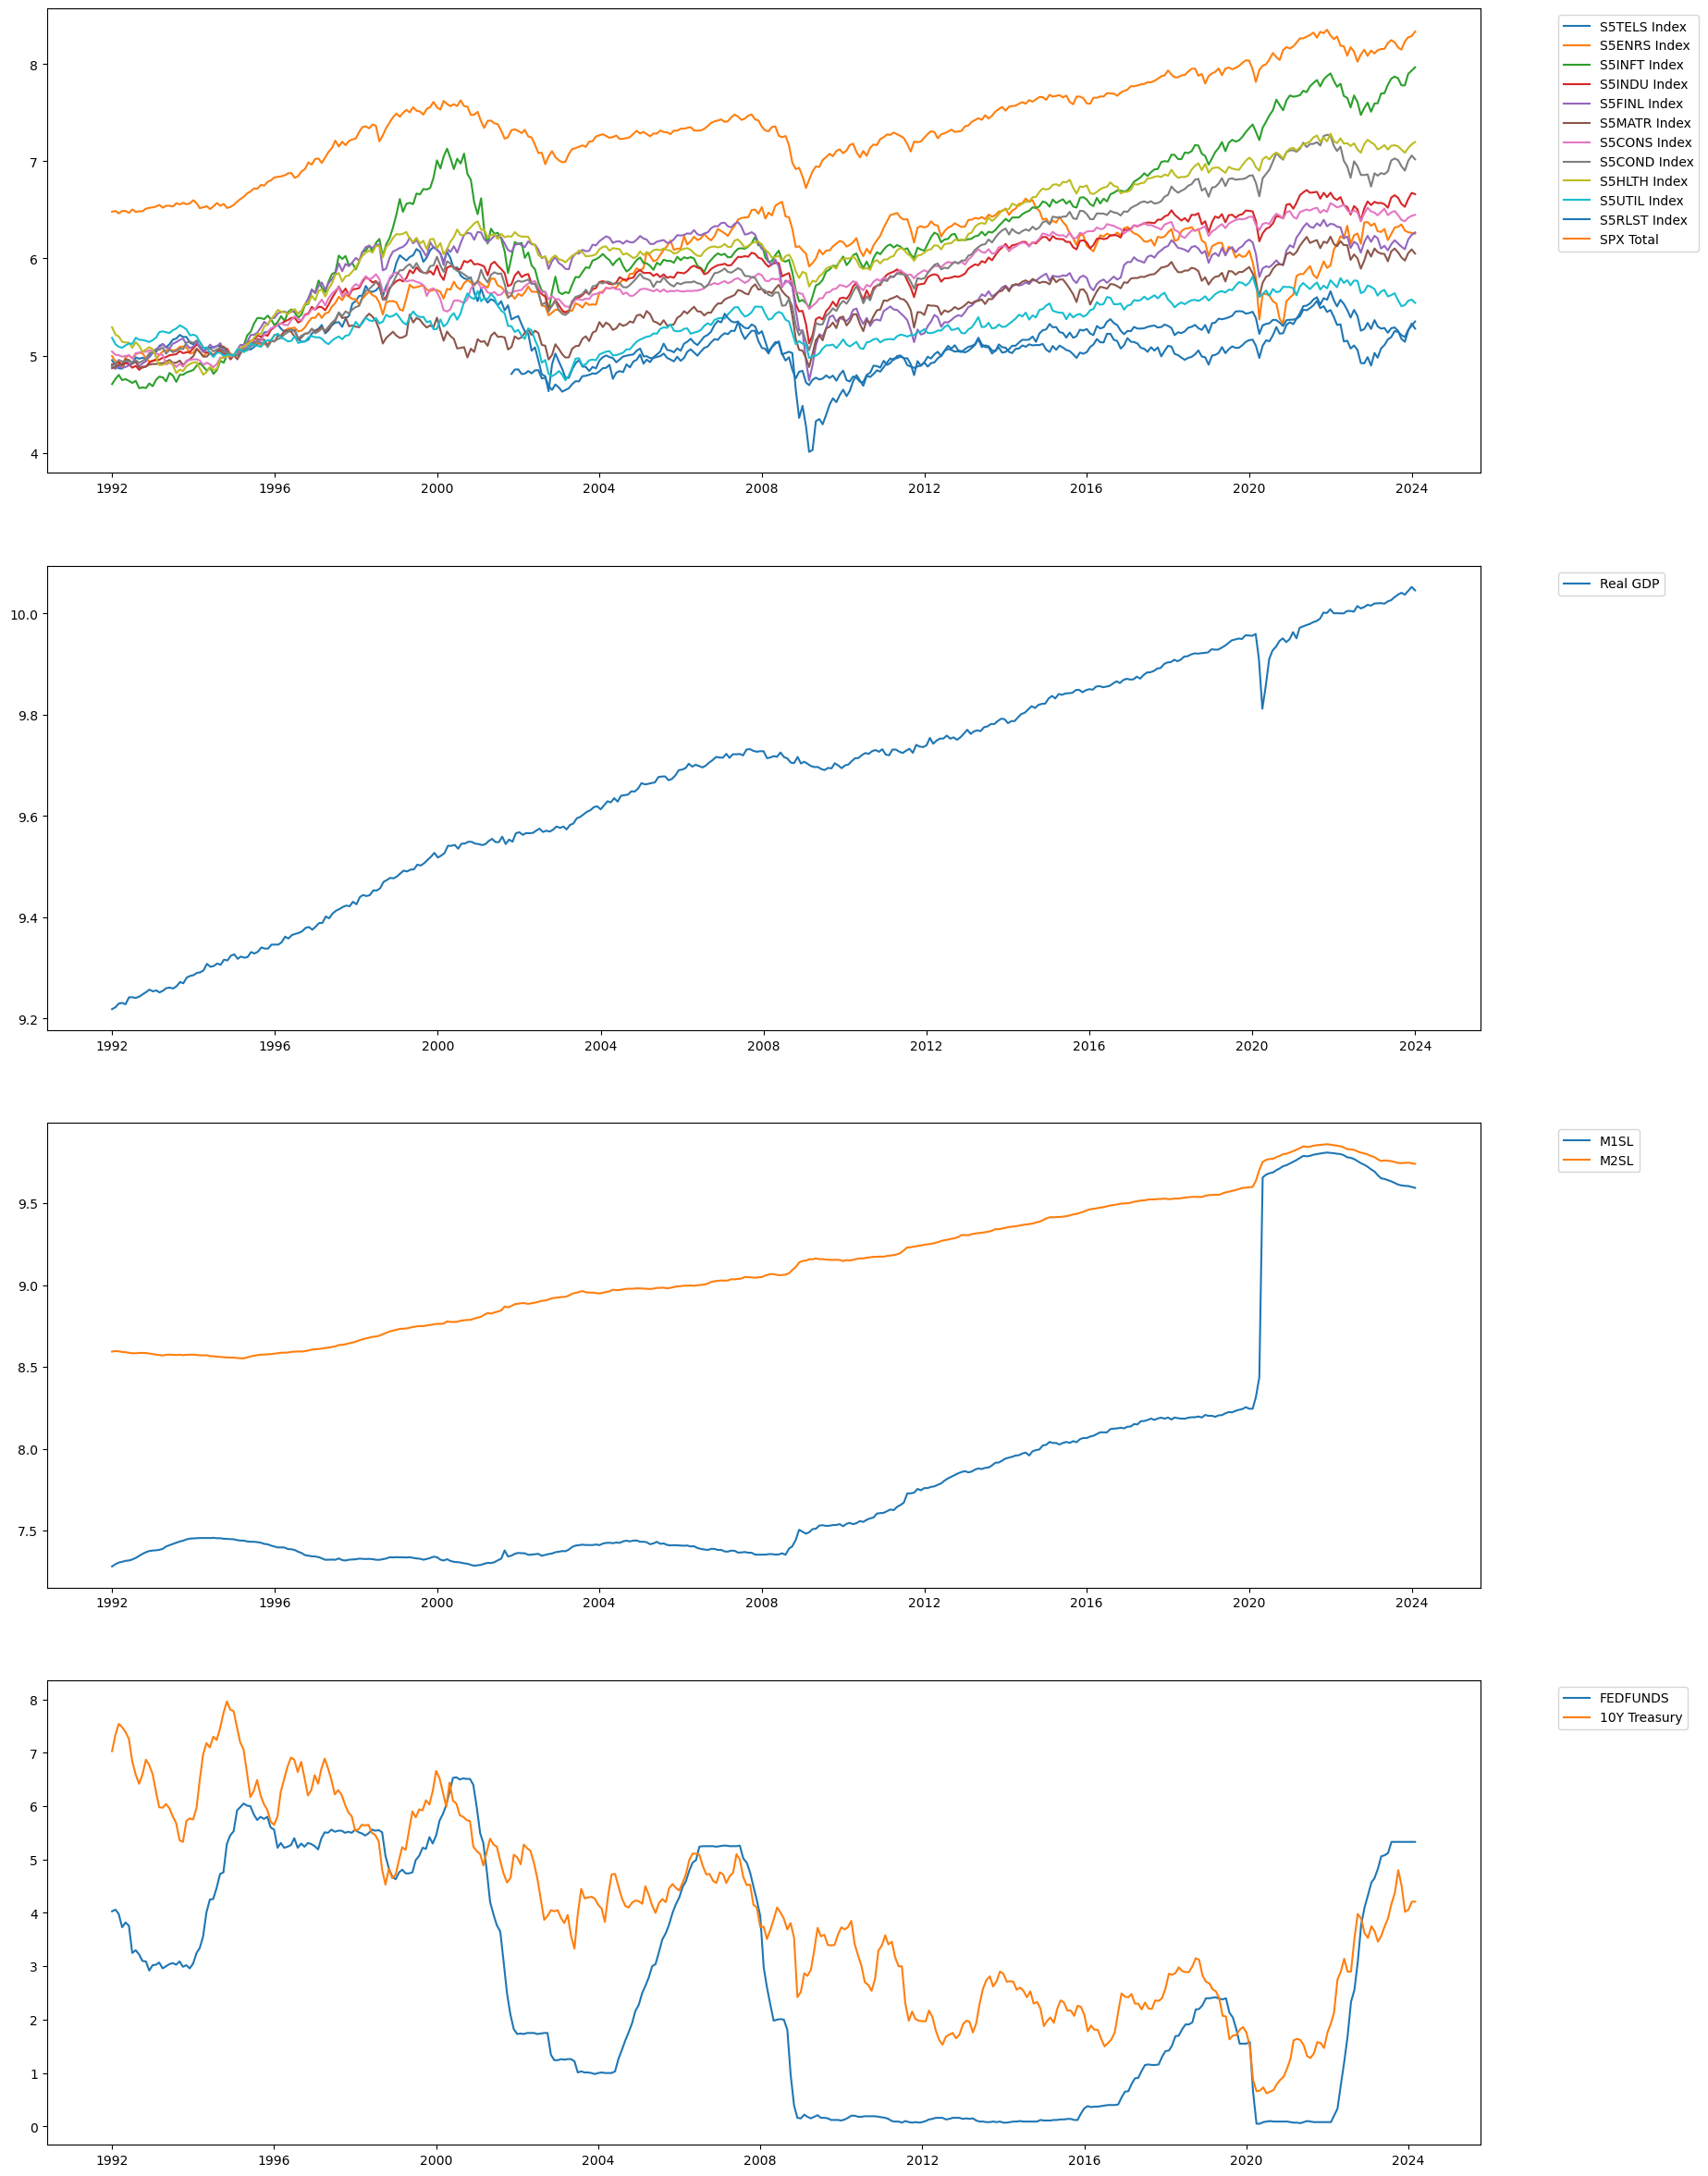

In [9]:
plt.figure(figsize=(20, 30))
ax = plt.subplot(411)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(412)
ax.plot(treated_vars.index, treated_vars[['GDP']])
ax.legend(['Real GDP'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(413)
ax.plot(treated_vars.index, treated_vars[['M1SL', 'M2SL']])
ax.legend(['M1SL', 'M2SL'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(414)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [10]:
summary_df = pd.DataFrame(index=['ADF Test', 'PhillipsPerron Test'])
summary_df = summary_df.astype(str)

# Perform ADF test with Newey-West standard errors for each variable
for industry in industry_names:
    summary_df = run_tests_ct(treated_vars[industry], summary_df)

run_tests_ct(treated_vars['GDP'], summary_df)
run_tests_ct(treated_vars['M1SL'], summary_df)
run_tests_ct(treated_vars['M2SL'], summary_df)
run_tests_c(data['FEDFUNDS'], summary_df)
run_tests_c(data['10Y Treasury'], summary_df)

/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.05' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-2.11' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc['ADF Test', variable.name] = str(adf_statistic) + asterisk_adf
/var/folders/3q/7_gwq5997wbf8dgrj2mb_f700000gn/T/ipykernel_23402/2836617440.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.46' has d

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,SPX Total,GDP,M1SL,M2SL,FEDFUNDS,10Y Treasury
ADF Test,-3.05,-2.11,-1.46,-2.49,-2.13,-3.94**,-2.16,-1.98,-2.12,-3.43**,-2.78,-1.71,-2.2,-1.29,-3.82**,-2.74*,-2.21
PhillipsPerron Test,-2.45,-2.15,-1.78,-2.62,-2.17,-4.02,-2.37,-2.14,-1.88,-2.98,-2.84,-1.98,-2.37,-1.37,-3.19,-1.68***,-1.98***


##Var model for exog variables

In [20]:
#By definition, lag length for each variable is '12 * (nobs/100) ** (1/4)'

lag_df = pd.DataFrame(index=['nlags'])

pp_nlag(data['FEDFUNDS'], 'c', lag_df)
pp_nlag(data['10Y Treasury'], 'c', lag_df)

,FEDFUNDS,10Y Treasury
nlags,17.0,17.0


In [26]:
X = data[['FEDFUNDS', '10Y Treasury']].dropna().copy()
# Fit VAR model
model = VAR(X)
print(model.select_order(maxlags=20, trend='c').summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.526       1.547       4.599       1.534
1       -6.480      -6.416    0.001533      -6.455
2       -7.110     -7.004*   0.0008167      -7.068
3       -7.141      -6.992   0.0007923      -7.081
4       -7.170      -6.978   0.0007696     -7.094*
5       -7.156      -6.922   0.0007805      -7.063
6       -7.167      -6.890   0.0007718      -7.057
7      -7.174*      -6.855  0.0007661*      -7.047
8       -7.172      -6.811   0.0007676      -7.029
9       -7.171      -6.766   0.0007690      -7.010
10      -7.158      -6.711   0.0007785      -6.981
11      -7.143      -6.653   0.0007909      -6.948
12      -7.129      -6.597   0.0008016      -6.918
13      -7.121      -6.546   0.0008086      -6.892
14      -7.107      -6.490   0.0008197      -6.862
15      -7.108      -6.448   0.0008191      -6.846
16      -7.102      -6.399   0.

/opt/anaconda3/envs/Jarvis/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


We follow the AIC suggestion of 7 lags on interest rates for the VAR model

In [24]:
order = 7  # Order of VAR model
results = model.fit(order)

# Print summary of the model
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Apr, 2024
Time:                     12:24:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.88853
Nobs:                     380.000    HQIC:                  -7.07616
Log likelihood:           319.530    FPE:                0.000746949
AIC:                     -7.19960    Det(Omega_mle):     0.000691296
--------------------------------------------------------------------
Results for equation FEDFUNDS
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.029132         0.018118           -1.608           0.108
L1.FEDFUNDS             1.357286         0.051112           26.555           0.000
L1.10Y Treasury         0.157586         0.031272

In [27]:
roots = results.roots

all_stable = all(np.abs(root) > 1 for root in roots)
if all_stable:
    print("The VAR model is stable.")
else:
    print("The VAR model is not stable.")

The VAR model is stable.


We will now use this model to forecast the interest rates for the VECM.